**Actividad Semanal -- 7 Regresiones y K means**

---



Diego Alonso Luna Ramirez - A01793035

Profesor(a): María de la Paz Rico

Fecha: 8 Noviembre de 2022

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [4]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [6]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

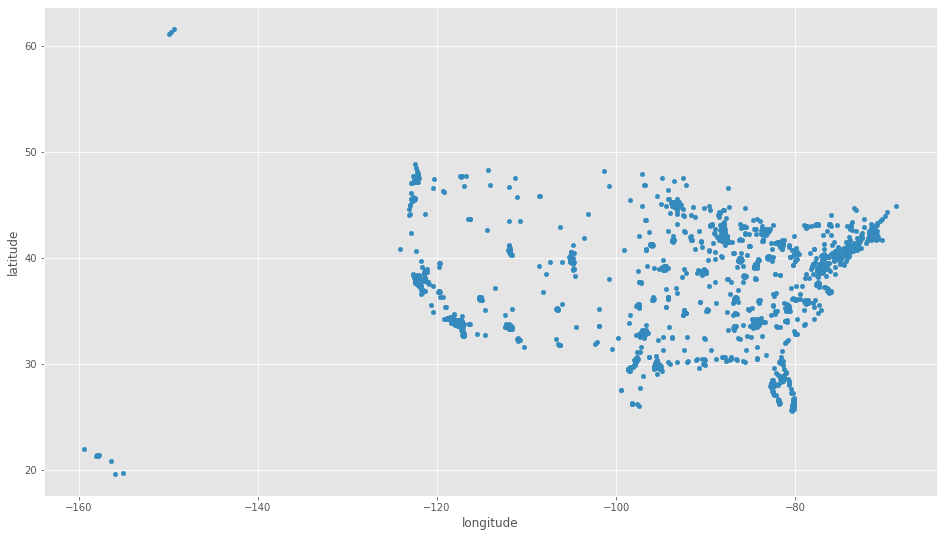

In [7]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [8]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [10]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [11]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [12]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [13]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

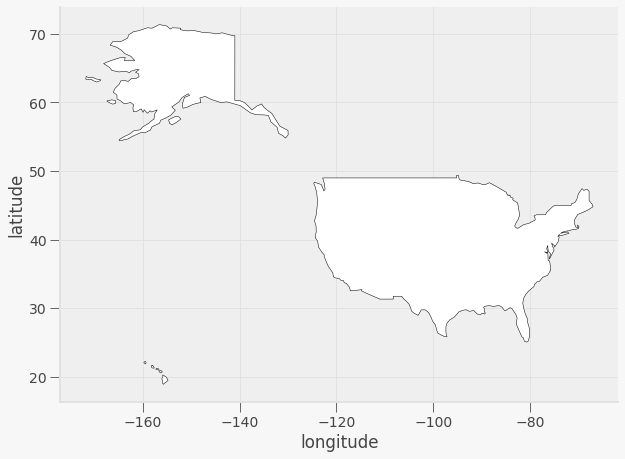

In [14]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

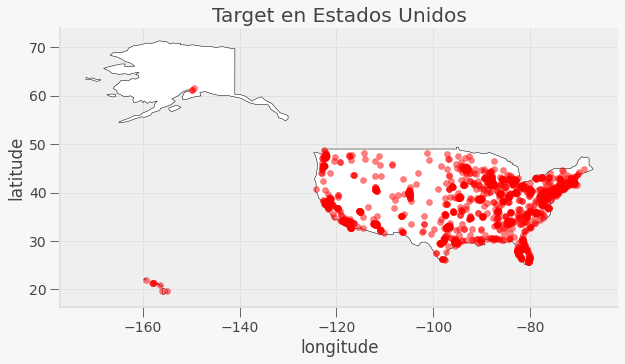

In [15]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

Encuentra el numero ideal de almacenes, justifica tu respuesta:

Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará? ¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.

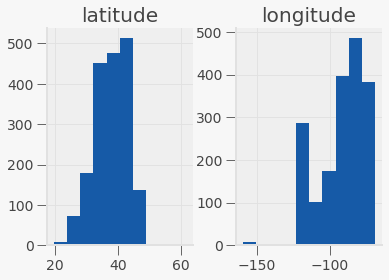

In [16]:
#Graficamos para tener una mejor visualización de la dispersión de los datos
latlong.hist()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


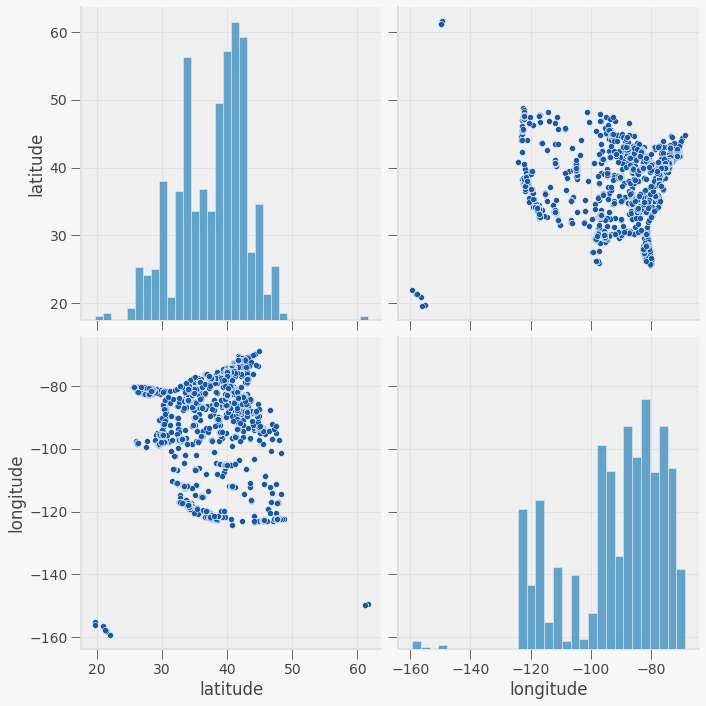

In [17]:
sb.pairplot(df.dropna(),size=5,vars=['latitude','longitude'],kind='scatter')

In [18]:
#Precisamos la estructura de datos para alimentar el algoritmo

X = np.array(df[['latitude', 'longitude']])
y = np.array(df['Coordinates'])
y.shape
type(X)

numpy.ndarray

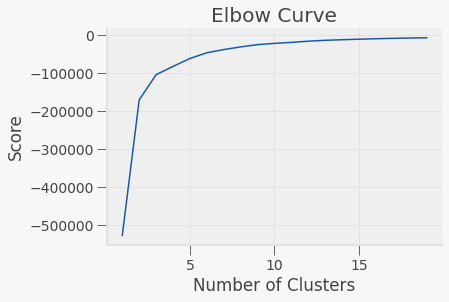

In [19]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Con la gráfica "ELBOW" definimos a K con un valor de 3 que es donde la linea cambia de dirección.

In [20]:
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[  37.789554    -78.56990807]
 [  37.48734203 -118.62447332]
 [  37.98006261  -93.3271723 ]]


Transformamos los datos en coordenadas

In [21]:
lt= ['longitude','latitude']
df_wh = pd.DataFrame(centroids, columns=['longitude','latitude'])
df_wh["Warehouse"] = list(zip(df_wh.latitude,df_wh.longitude))
df_wh["Warehouse"] = df_wh["Warehouse"].apply(Point)
df_wh['City'] = ['Scottsville, VA', 'Mono County, CA', 'Hickory County, MO']
df_wh

,longitude,latitude,Warehouse,City
0,37.789554,-78.569908,POINT (-78.56990807484885 37.789554004474006),"Scottsville, VA"
1,37.487342,-118.624473,POINT (-118.62447331844157 37.48734203064935),"Mono County, CA"
2,37.980063,-93.327172,POINT (-93.32717230430622 37.98006260590112),"Hickory County, MO"


In [22]:
gdf_wh = gpd.GeoDataFrame(df_wh, geometry="Warehouse")
gdf_wh.head()

,longitude,latitude,Warehouse,City
0,37.789554,-78.569908,POINT (-78.56991 37.78955),"Scottsville, VA"
1,37.487342,-118.624473,POINT (-118.62447 37.48734),"Mono County, CA"
2,37.980063,-93.327172,POINT (-93.32717 37.98006),"Hickory County, MO"


In [23]:
print('gdf is of type:', type(gdf_wh))

gdf is of type: <class 'geopandas.geodataframe.GeoDataFrame'>


In [24]:
print('\nThe geometry column is:', gdf.geometry.name)


The geometry column is: Coordinates


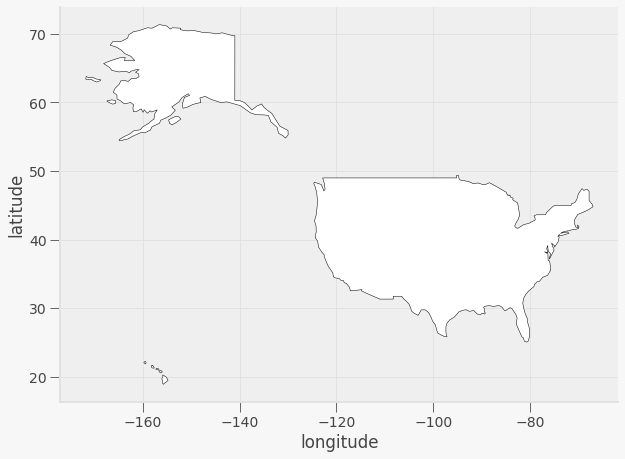

In [25]:
fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

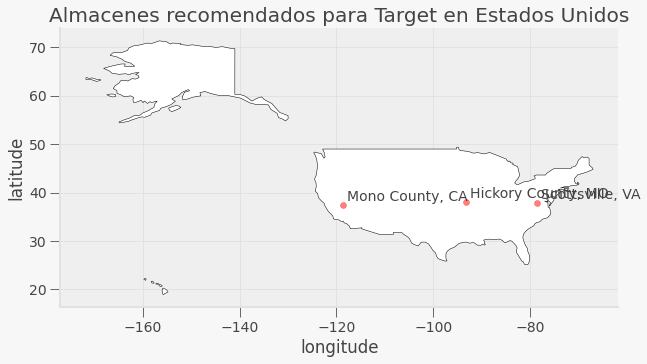

In [26]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf_wh.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Almacenes recomendados para Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# Label the cities
for x, y, label in zip(gdf_wh['Warehouse'].x, gdf_wh['Warehouse'].y, gdf_wh['City']):
  gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')

plt.show()

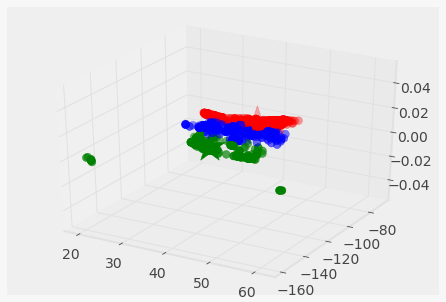

In [27]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)

Observamos con el algoritmo K-Means que "K=3" ha agrupado a diferentes tiendas de Target por su localización, teniendo en cuenta las 2 dimensiones que utilizamos.

Realizaremos algunas gráficas en 2 dimensiones con las proyecciones a partir de nuestra gráfica 3D para que nos ayude a visualizar los grupos y su clasificación.

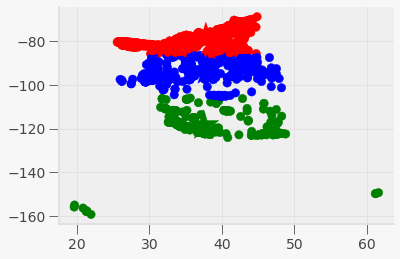

In [28]:
# Getting the values and plotting it
f1 = df['latitude'].values
f2 = df['longitude'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

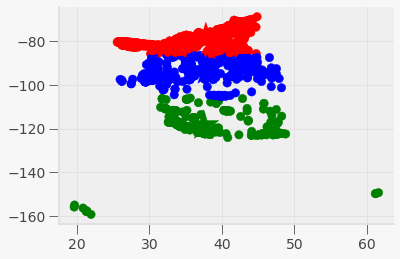

In [29]:
# Getting the values and plotting it
f1 = df['latitude'].values
f2 = df['longitude'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

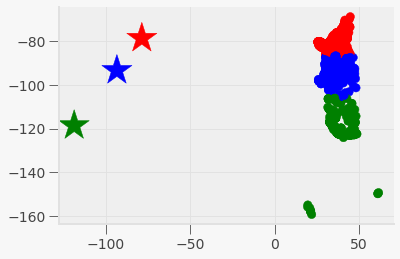

In [30]:
f1 = df['latitude'].values
f2 = df['longitude'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

Podemos ver cuantas tiendas hay en cada cluster

In [31]:
copy =  pd.DataFrame()
copy['latitude']=df['latitude'].values
copy['longitude']=df['longitude'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,826
1,green,385
2,blue,628


Podemos observar la tiendas mas cerca de su centroide

In [32]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

array([1689,  212,  998])

In [33]:
stores=df['Coordinates'].values
for row in closest:
    print(stores[row])

POINT (-78.44076369999999 38.1289566)
POINT (-119.6989832 36.8065383)
POINT (-92.6029586 38.1610749)


Vemos las coordenadas de las tiendas más cercanas a los centroides.
De igual forma, podemos agrupar y etiquetar nuevas localidades con sus características y clasificarlas. Vemos el ejemplo con la tienda de Alabaster y nos devuelve que pertenece al grupo 3.

In [34]:
X_new = np.array([[33.224225, -86.804174]])

new_labels = kmeans.predict(X_new)
print(new_labels)

[2]


**¿Qué librerías nos pueden ayudar a graficar este tipo de datos?**
Numpy, Geemap, PyViz/HoloViz, Geopandas y Matplotlib

**¿Consideras importante que se grafique en un mapa? ¿por qué? **
Si, ya que facilitan la visualización de mapas, mostrar demasiada información en capas distintas, ademas de ser interactivas, poder escoger.

**Conclusiones**

Estas nuevas librerias geoespaciales, son demasiado utiles para precisar mucha información que pueda ser necesario en temas de logistica y analisis, esta practica da una muestra de lo util que puede ser este tipo de librerias, impulsando mejor su utilidad con el uso de librerias de ciertos modelos previamente visto.